In [1]:
import pandas as pd
import numpy as np
import torch
import sklearn.model_selection
import matplotlib.pyplot as plt
import os
import re

In [2]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'

Data was acquired from [this kaggle link](https://www.kaggle.com/competitions/facial-keypoints-detection)

## Load the file

In [3]:
all_data = pd.read_csv('training.csv')

In [4]:
all_data

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [5]:
all_data.dropna().shape  # lots of NaNs

(2140, 31)

In [6]:
len(all_data.columns) - 1  # number of features except Image

30

30 total dimentions. This means 15 2D points. 6 for eyes (3 for each eye), 4 for eyebrows (2 each), 1 for nose, 2 for mouth corner, 2 for lip centers.

In [7]:
all_data.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

For now, lets just not worry about all the NaNs and just work with a column thats not too bad.

In [8]:
np.any(np.isnan(all_data['left_eye_center_x'].array))

True

In [9]:
pd.isna(all_data['left_eye_center_x'])

0       False
1       False
2       False
3       False
4       False
        ...  
7044    False
7045    False
7046    False
7047    False
7048    False
Name: left_eye_center_x, Length: 7049, dtype: bool

In [10]:
all_data = all_data[~(pd.isna(all_data['left_eye_center_x']) | pd.isna(all_data['left_eye_center_y']))].reset_index(drop=True)

## Split the data into train and test

In [11]:
test_fraction = 0.1
test_index = int((1-test_fraction)*len(all_data))
train_data, test_data = all_data[:test_index], all_data[test_index:]

In [12]:
len(train_data), len(test_data)

(6335, 704)

In [13]:
train_data, test_data = sklearn.model_selection.train_test_split(all_data, test_size=0.1)

In [14]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [15]:
list(map(len, (train_data, test_data)))

[6335, 704]

## Preprocces the data

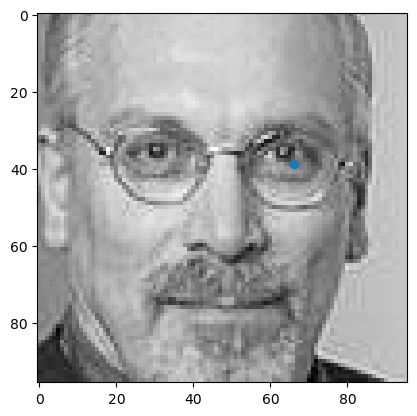

In [16]:
idx = 0
plt.imshow(np.array(list(map(int, train_data.at[idx, 'Image'].split()))).reshape((96, 96)), cmap='gray')
plt.scatter([train_data.at[idx, 'left_eye_center_x']], [train_data.at[idx, 'left_eye_center_y']])

### Create a torch Dataset class

In [17]:
class IntStrFaces(torch.utils.data.Dataset):
    SHAPE = (96, 96)
    
    def __init__(self, df, transform=None, target_transform=None, point_name='left_eye_center'):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        self.point_name = point_name
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = map(int, self.df.at[idx, 'Image'].split())
        image = np.array(list(image)).reshape(self.SHAPE)
        if self.transform:
            image = self.transform(image)
            
        label = np.array(self.df.iloc[idx][self.point_name + '_x':self.point_name + '_y'], dtype=float)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [18]:
np.array(all_data.iloc[1]['left_eye_center_x':'left_eye_center_y'], dtype=float)

array([64.33293617, 34.9700766 ])

We want coordinates to be in the interval [-1, 1].

In [19]:
coord_transform = lambda v: 2 * v / 96 - 1
coord_fix = lambda u: (u + 1) * 96 / 2

In [20]:
train_dataset = IntStrFaces(
    train_data, 
    transform=lambda arr: torch.tensor(arr/255, dtype=torch.float32).unsqueeze(0),
    target_transform=lambda arr: torch.tensor(coord_transform(arr), dtype=torch.float32)
)
test_dataset = IntStrFaces(
    test_data,
    transform=lambda arr: torch.tensor(arr/255, dtype=torch.float32).unsqueeze(0),
    target_transform=lambda arr: torch.tensor(coord_transform(arr), dtype=torch.float32)
)

In [21]:
train_dataset[0]

(tensor([[[0.4941, 0.4941, 0.5451,  ..., 0.6667, 0.6784, 0.6784],
          [0.5098, 0.4941, 0.5137,  ..., 0.6745, 0.6824, 0.6824],
          [0.5098, 0.4941, 0.4667,  ..., 0.6784, 0.6863, 0.6824],
          ...,
          [0.1373, 0.1608, 0.2039,  ..., 0.6784, 0.6902, 0.6706],
          [0.1804, 0.1922, 0.2078,  ..., 0.6510, 0.6235, 0.6627],
          [0.2000, 0.2039, 0.2000,  ..., 0.7176, 0.7294, 0.6941]]]),
 tensor([ 0.3761, -0.1942]))

# Let's try a Spatial Transformer
We want to do a one hot approach, but this has a severe lack in presicion. We can make up for this by resampling only in the relevant area, then inverting the position through the resampler.

In [55]:
# Attempt 1
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # theta determines where to grid sample the image
        self.theta = torch.nn.Sequential(
            # shape (n, 1, 96, 96)
            
            torch.nn.Conv2d(1, 8, kernel_size=17),
            # shape (n, 8, 80, 80)
            torch.nn.MaxPool2d(2),
            # shape (n, 8, 40, 40)
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(8, 12, kernel_size=11),
            # shape (n, 12, 30, 30)
            torch.nn.MaxPool2d(2),
            # shape (n, 12, 15, 15)
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(12, 14, kernel_size=6),
            # shape (n, 14, 10, 10)
            torch.nn.MaxPool2d(2),
            # shape (n, 14, 5, 5)
            torch.nn.ReLU(True),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(14 * 5 * 5, 64),
            torch.nn.ReLU(),
            
            torch.nn.Linear(64, 6)
        )
        
        # we feed the sample to the main net
        self.main_net = torch.nn.Sequential(
            # 2 convolution layers
            # shape (n, 1, 24, 24)
            torch.nn.Conv2d(1, 6, kernel_size=9),
            # shape (n, 6, 16, 16)
            torch.nn.MaxPool2d(2),
            # shape (n, 6, 8, 8)
            torch.nn.ReLU(True),
            torch.nn.Conv2d(6, 12, kernel_size=5),
            # shape (n, 12, 4, 4)
            torch.nn.Dropout2d(p=0.8),
            torch.nn.MaxPool2d(2),
            # shape (n, 12, 2, 2)
            torch.nn.ReLU(True),
            torch.nn.Flatten(),
            torch.nn.Linear(12 * 2 * 2, 10),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.8),
            torch.nn.Linear(10, 2)
        )
        
        # we want the grid sample transformation to start as the identity
        self.theta[-1].weight.data.zero_()
        self.theta[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=float))
    
    def stn(self, x):
        SIZE = (24, 24)
        theta = self.theta(x)
        theta = theta.view(-1, 2, 3)
        grid = torch.nn.functional.affine_grid(theta, (theta.size(0), 1) + SIZE)
        # theta = torch.cat([theta, torch.tensor([[[0, 0, 1]]])], dim=1)
        sample = torch.nn.functional.grid_sample(x, grid)
        return sample, theta
    
    def forward(self, x):
        sample, theta = self.stn(x)
        local_coords = self.main_net(sample)
        
        local_coords = torch.cat([local_coords, torch.ones(local_coords.size(0), 1, device=local_coords.device)], dim=1)
        
        # row = torch.tensor([[0, 0, 1]], device=local_coords.device).expand(local_coords.size(0), -1, -1)
        # theta = torch.cat([theta, row], dim=1)
        # theta_inv = torch.linalg.inv(theta)[:, :2, :]
        
        # coords = torch.bmm(local_coords.unsqueeze(1), theta_inv.mT).squeeze()
        
        coords = torch.bmm(local_coords.unsqueeze(1), theta.mT).squeeze()
        
        return coords

In [56]:
torch.nn.functional.affine_grid(torch.tensor([[[2, 0, 0], [0, 2, 0]]], dtype=float), (1, 1, 3, 3))

tensor([[[[-1.3333, -1.3333],
          [ 0.0000, -1.3333],
          [ 1.3333, -1.3333]],

         [[-1.3333,  0.0000],
          [ 0.0000,  0.0000],
          [ 1.3333,  0.0000]],

         [[-1.3333,  1.3333],
          [ 0.0000,  1.3333],
          [ 1.3333,  1.3333]]]], dtype=torch.float64)

In [57]:
theta = torch.tensor([[[2, 1, 0], [0, 2, 0]]], dtype=float)
row = torch.tensor([[[0, 0, 1]]])
theta = torch.cat([theta, row], dim=1)
torch.linalg.inv(theta)[:, :2, :]

tensor([[[ 0.5000, -0.2500,  0.0000],
         [ 0.0000,  0.5000,  0.0000]]], dtype=torch.float64)

In [58]:
theta = torch.tensor([[[2, 1, 0], [0, 2, 0]]], dtype=float)
theta_inv = torch.linalg.inv(torch.cat([theta, row], dim=1))[:, :2, :]
torch.cat([torch.nn.functional.affine_grid(theta, (1, 1, 3, 3))[0, 0, 0], torch.tensor([1])]) @ theta_inv.mT

tensor([[-0.6667, -0.6667]], dtype=torch.float64)

In [59]:
v = torch.arange(10).reshape(5, 2).to(float)

In [60]:
M = torch.tensor([[[1, 0], [1, 2]] for _ in range(5)], dtype=float)

In [61]:
torch.bmm(v.unsqueeze(1), M.mT)

tensor([[[ 0.,  2.]],

        [[ 2.,  8.]],

        [[ 4., 14.]],

        [[ 6., 20.]],

        [[ 8., 26.]]], dtype=torch.float64)

In [62]:
torch.cat([v, torch.ones(v.size(0), 1)], dim=1)

tensor([[0., 1., 1.],
        [2., 3., 1.],
        [4., 5., 1.],
        [6., 7., 1.],
        [8., 9., 1.]], dtype=torch.float64)

## Now lets train the model

In [63]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

In [64]:
loss_fn = torch.nn.functional.mse_loss

In [65]:
model = Net().to('cuda')
optimizer = torch.optim.Adam(model.parameters())

def train(epoch, report_freq=100):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % report_freq == report_freq - 1:
            print(f'Epoch {epoch}: {batch_idx*len(data)}/{len(train_dataloader.dataset)} Loss: {total_loss/report_freq:.6f}')
            total_loss = 0

In [66]:
def test(model, test_loader, loss_fn, logging=True):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch, (X, y) in enumerate(test_loader):
            X, y = X.to(device).type(torch.float32), y.to(device).type(torch.float32)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            if logging and batch % 100 == 0:
                print(f"Batch {batch}")
        test_loss /= len(test_loader)
        if logging:
            print(f"Avg loss per batch: {test_loss:>8f} \n")
    return test_loss

In [67]:
os.listdir('.')

['training.zip',
 '.git',
 '.ipynb_checkpoints',
 'test.csv',
 'Facial point detection.ipynb',
 'test.zip',
 'facial-keypoints-detection.zip',
 'SampleSubmission.csv',
 'training.csv',
 'checkpoints',
 'IdLookupTable.csv']

In [68]:
checkpoints_folder = './checkpoints'
os.makedirs(checkpoints_folder, exist_ok=True)

In [69]:
# initial checkpoint
location = os.path.join(checkpoints_folder, f'checkpoint_epoch_0.pth')
torch.save({
    'epoch': 0,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_loss': test(model, train_dataloader, loss_fn, logging=False),
    'test_loss': test(model, test_dataloader, loss_fn, logging=False)
},
location)
for epoch in range(15):
    train(epoch)
    
    # save a checkpoint
    location = os.path.join(checkpoints_folder, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch+1,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_loss': test(model, train_dataloader, loss_fn, logging=False),
        'test_loss': test(model, test_dataloader, loss_fn, logging=False)
    },
    location)

Epoch 0: 3168/6335 Loss: 0.018958
Epoch 1: 3168/6335 Loss: 0.006265
Epoch 2: 3168/6335 Loss: 0.004923
Epoch 3: 3168/6335 Loss: 0.004670
Epoch 4: 3168/6335 Loss: 0.004787
Epoch 5: 3168/6335 Loss: 0.004640
Epoch 6: 3168/6335 Loss: 0.004075
Epoch 7: 3168/6335 Loss: 0.003994
Epoch 8: 3168/6335 Loss: 0.003438
Epoch 9: 3168/6335 Loss: 0.003002
Epoch 10: 3168/6335 Loss: 0.002552
Epoch 11: 3168/6335 Loss: 0.002868
Epoch 12: 3168/6335 Loss: 0.002553
Epoch 13: 3168/6335 Loss: 0.002161
Epoch 14: 3168/6335 Loss: 0.002476


Lets look at the loss

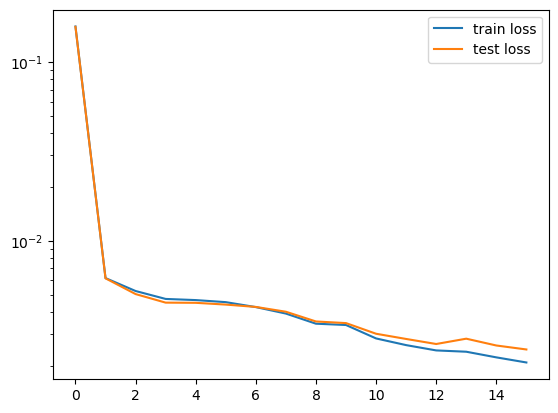

In [70]:
points = []
for checkpoint_fp_head in os.listdir(checkpoints_folder):
    checkpoint_fp = os.path.join(checkpoints_folder, checkpoint_fp_head)
    checkpoint = torch.load(checkpoint_fp, map_location=device)
    points.append((checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']))
points.sort()
points = np.array(points)
plt.plot(points[:, 0], points[:, 1], label='train loss')
plt.plot(points[:, 0], points[:, 2], label='test loss')
plt.yscale('log')
plt.legend()

tensor([[[ 1.0231,  0.2424,  0.1870],
         [-0.1698,  0.7169, -0.3001]]], device='cuda:0')

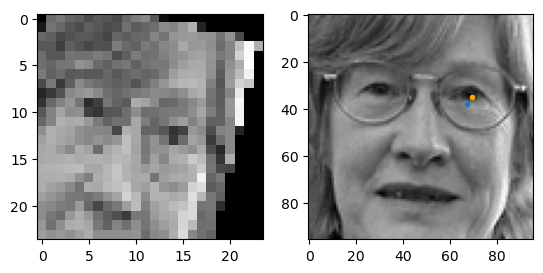

In [71]:
fig, axs = plt.subplots(1, 2)
with torch.no_grad():
    model.eval()
    test_idx = 7
    test_val = train_dataset[test_idx][0].unsqueeze(0).to('cuda')
    sample = model.stn(test_val)[0].cpu()
    theta = model.theta(test_val)
    theta = theta.view(-1, 2, 3)
    grid = torch.nn.functional.affine_grid(theta, (theta.size(0), 1) + (24, 24))
    coords = model(test_val)

axs[0].imshow(sample.squeeze(), cmap='gray')
axs[1].imshow(test_val.cpu().squeeze(), cmap='gray')
axs[1].scatter(*coord_fix(coords).unsqueeze(-1).cpu(), marker='.')
axs[1].scatter(*coord_fix(train_dataset[test_idx][1]).unsqueeze(-1).cpu(), marker='.', color='orange')
theta

In [72]:
train_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 1, 96, 96])

In [73]:
t1 = model.theta(train_dataset[0][0].unsqueeze(0).to('cuda'))#.view(-1, 2, 3)

In [74]:
model.theta[0].bias.data.dtype

torch.float32

In [75]:
t2 = torch.cat([t1, t1], dim=0)

In [76]:
t1

tensor([[ 1.0213,  0.2297,  0.1778, -0.1690,  0.7269, -0.2907]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [77]:
test(Net().to(device), test_dataloader, torch.nn.functional.mse_loss)

Batch 0
Avg loss per batch: 0.114374 



0.11437359249049966

In [78]:
test(model, train_dataloader, torch.nn.functional.mse_loss)

Batch 0
Batch 100
Avg loss per batch: 0.002086 



0.002085656996856378

In [79]:
test(model, test_dataloader, torch.nn.functional.mse_loss)

Batch 0
Avg loss per batch: 0.002466 



0.002466038903962313

tensor([[[ 1.0391,  0.2140,  0.1690],
         [-0.1478,  0.7671, -0.2486]]], device='cuda:0')

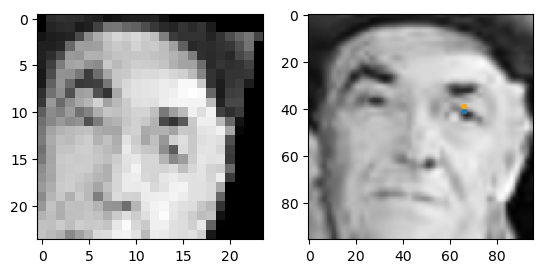

In [80]:
fig, axs = plt.subplots(1, 2)
with torch.no_grad():
    model.eval()
    test_idx = 0
    test_val = test_dataset[test_idx][0].unsqueeze(0).to('cuda')
    sample = model.stn(test_val)[0].cpu()
    theta = model.theta(test_val)
    theta = theta.view(-1, 2, 3)
    grid = torch.nn.functional.affine_grid(theta, (theta.size(0), 1, 24, 24))
    coords = model(test_val)

axs[0].imshow(sample.squeeze(), cmap='gray')
axs[1].imshow(test_val.cpu().squeeze(), cmap='gray')
axs[1].scatter(*coord_fix(coords).unsqueeze(-1).cpu(), marker='.')
axs[1].scatter(*coord_fix(train_dataset[test_idx][1]).unsqueeze(-1).cpu(), marker='.', color='orange')
theta

Next step is to see how this performs if we drop faces in various positions against a background.

In [81]:
(theta.size(0), 1) + (24, 24)


(1, 1, 24, 24)